# Project: ML - LogisticRegression, KNN and RandomForests (Titanic)

<br>

## Questions to address:
- Predict survival from data on Titanic passengers

<br>

## Tools:
- Models: 
  - Logistic Regression
  - K-nearest neighbors
  - Random Forests  
- Feature Preparation, Selection and Engineering:
  - fill NaNs with mean or top value
  - bin data to create new categories using pd.cut()
  - extract data from text columns
  - create dummies
  - RFECV feature selection
- Model selection with GridSearchCV 
- Error Metric: ROC_AUC and Accuracy

<br>

### load defaults

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import requests 

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.dates as mdates
from datetime import datetime
from IPython.display import display, Math

from functions import *

plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green', '#9E80BA', '#8EDB8E', '#58517A']
Ncolors = 10
color_map = plt.cm.Blues_r(np.linspace(0.2, 0.5, Ncolors))
#color_map = plt.cm.tab20c_r(np.linspace(0.2, 0.5, Ncolors))


#specific to this project
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

print("Defaults Loaded")

Defaults Loaded


<br>

## Dataset: Titanic

In [2]:
train = pd.read_csv('./data/titanic_train.csv')
holdout = pd.read_csv('./data/titanic_test.csv')

display(holdout[:2])

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


<br>

### Feature Preparation, Selection and Engineering

In [3]:
def process_missing(df):
    #Handle various missing values
    df["Fare"] = df["Fare"].fillna(df["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    #Process the Age column into pre-defined 'bins' 

    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    df.drop("Age", axis=1, inplace=True)
    return df

def process_fare(df):
    #Process the Fare column into pre-defined 'bins' 
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    df.drop("Fare", axis=1, inplace=True)
    return df

def process_cabin(df):
    #Process the Cabin column into pre-defined 'bins' 
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df.drop('Cabin',axis=1, inplace=True)
    return df

def process_titles(df):
    #Extract and categorize the title from the name column 
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):   
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    df.drop(column_name, axis=1, inplace=True)
    return df

def process_columns(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    columns = ['Age_categories', 'Fare_categories', 'Cabin_type', 'Sex', 'Title', 'Embarked']
    df = create_dummies(df, columns)
    
    return df

In [4]:
train = process_columns(train)
holdout = process_columns(holdout)

display(train.iloc[:2,:10])

,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Age_categories_Missing,Age_categories_Infant,Age_categories_Child
0,1,0,3,"Braund, Mr. Owen Harris",1,0,A/5 21171,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,0,0,0


further data exploration: create new feature, relatives

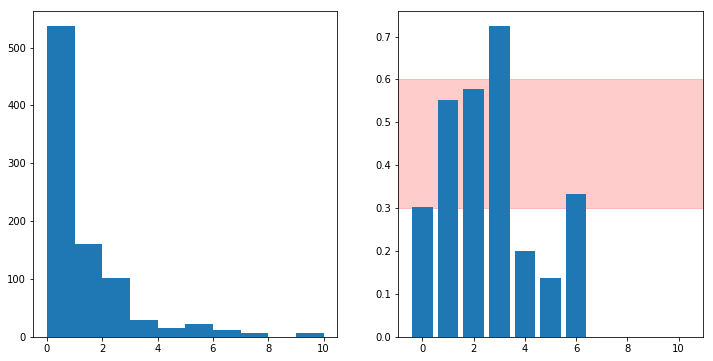

In [5]:
train['Relatives'] = train['SibSp'] + train['Parch']
holdout['Relatives'] = holdout['SibSp'] + holdout['Parch']

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
ax.hist(train['Relatives'],10)
ax = fig.add_subplot(1,2,2)
ax.axhspan(.3, .6, alpha=0.2, color='red')
pivot_table = train.pivot_table(index='Relatives', values='Survived')
ax.bar(pivot_table.index.values, [x[0] for x in pivot_table.values])   
plt.show()

only 30% survival if no relatives, create new column: is_alone

In [6]:
def is_alone(df):
    df['isalone'] = 0
    #df['isalone'][df['Relatives']==0] = 1 
    df.loc[(df["Relatives"] == 0),"isalone"] = 1   
    return df

train = is_alone(train)
holdout = is_alone(holdout)

#retain only the new colum isalone
#cols_to_drop = ['Relatives', 'SibSp', 'Parch']
#train.drop(cols_to_drop, axis=1, inplace=True)
#holdout.drop(cols_to_drop, axis=1, inplace=True)

display(train.iloc[:3,[0,1,2,-1]])

,PassengerId,Survived,Pclass,isalone
0,1,0,3,0
1,2,1,1,0
2,3,1,3,1


<br>

### Feature selection using LogisticRegression.coef_

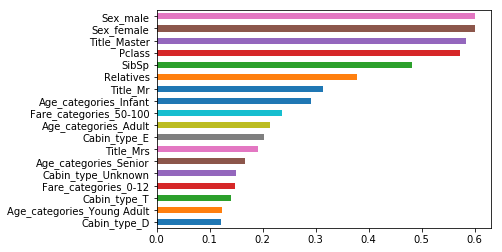

In [7]:
train_new = train.select_dtypes([np.number]).dropna(axis=1)
train_new = train_new.apply(lambda x: (x-x.mean())/x.std())

columns = train_new.drop(['Survived'],axis=1).columns
    
lr = LogisticRegression(solver='lbfgs', max_iter=5000)
lr.fit(train_new.drop(['Survived'],axis=1), train['Survived'])
coefficients = lr.coef_
feature_importance = pd.Series(coefficients[0], index=columns)

ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance[ordered_feature_importance>0.1].plot.barh()
plt.show()

<br>

### RFECV feature selection

In [8]:
def select_features(df):    
    #select numeric and drop NaNs
    df_new = df.select_dtypes([np.number]).dropna(axis=1)
    #drop survived and ID
    all_X = df_new.drop(['Survived','PassengerId'],axis=1)
    all_y = df_new['Survived']
    
    clf = RandomForestClassifier(n_estimators=50)
    #cv is the number of folds
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_y)    
    optimized_columns = list(all_X.columns[selector.support_])
    
    print("Best Columns \n"+"-"*12+"\n{}\n".format(optimized_columns))
    
    return optimized_columns

optimized_columns = select_features(train)

Best Columns 
------------
['Pclass', 'SibSp', 'Parch', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Relatives', 'isalone']



<br>

### Use sns.heatmap to check for collinearity

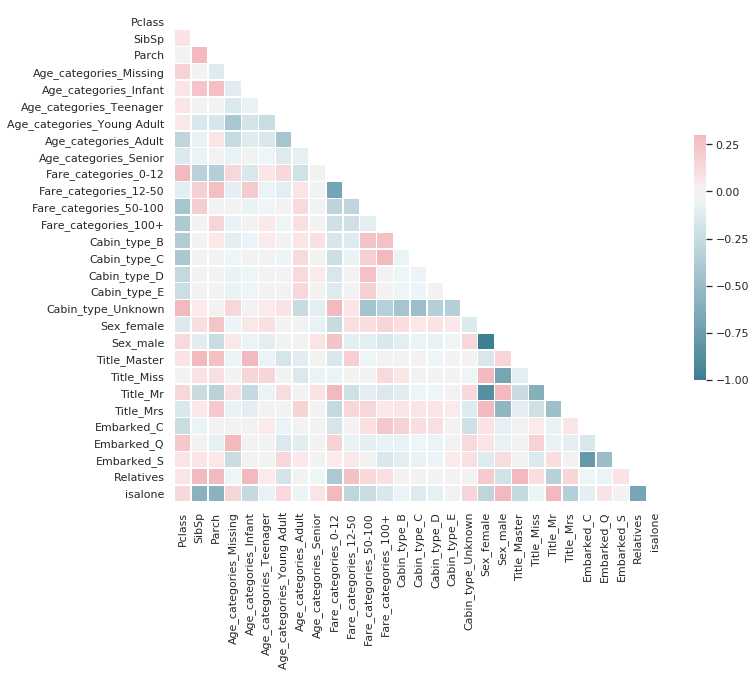

Best Columns 
------------
['Pclass', 'SibSp', 'Parch', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Relatives', 'isalone']



In [9]:
corr = train[optimized_columns].corr()

sns.set(style="white")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)


sns.heatmap(corr[corr<0.9], mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

#remove Sex_male since it has the same information as Sex_female
optimized_columns = [x for x in optimized_columns if x !='Sex_male']

collinear_cols = []
for element in optimized_columns:
    element_corr = corr[element]
    sel_1 = (element_corr>0.9) & (element_corr<1.0)
    sel_2 = (element_corr<-0.9) & (element_corr>-1.0)  
    if(len(element_corr[sel_1])>0):
        collinear_cols.append(element)
    if(len(element_corr[sel_2])>0):
        collinear_cols.append(element)
        
#remove columns with too much collinearity from optimized_columns
for element in set(collinear_cols):
    optimized_columns = [x for x in optimized_columns if x !=element]
    
#optimized_columns.append('Sex_female')
    
print("Best Columns \n"+"-"*12+"\n{}\n".format(optimized_columns))

In [27]:
def select_model(df, features_list):
    all_X = df[features_list]
    all_y = df['Survived']
    
    dicts= [ {
               "name": "LogisticRegression",
               "estimator": LogisticRegression(max_iter = 5000),
               "hyperparameters": 
                 {                
                   "solver": ["newton-cg", "lbfgs", "liblinear"]                      
                 }
             },
             {
               "name": "KNeighborsClassifier",
               "estimator": KNeighborsClassifier(),
               "hyperparameters": 
                 {
                   "n_neighbors": range(1,20,2),
                   "weights": ["distance", "uniform"],
                   "algorithm": ["ball_tree", "kd_tree", "brute"],
                   "p": [1,2]
                 }
             },
             {
               "name": "RandomForestClassifier",
               "estimator": RandomForestClassifier(),
               "hyperparameters": 
                 {
                   "n_estimators": [4, 6, 9],
                   "criterion": ["entropy", "gini"],
                   "max_depth": [2, 5, 10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1, 5, 8],
                   "min_samples_split": [2, 3, 5]                
                 }
             } ]
    
    scoring = {'AUC': 'roc_auc', 'Accuracy': 'accuracy'}
    for element in dicts:
        print(element['name'])
        print('-'*len(element['name']))
        
        model = element['estimator']
        grid = GridSearchCV(model, element['hyperparameters'], cv=10, scoring=scoring, refit='AUC', iid=True)
        grid.fit(all_X, all_y)
        
        element['best_params'] = grid.best_params_
        element['best_score'] = grid.best_score_
        element['best_estimator'] = grid.best_estimator_          
        for scorer in scoring:          
            print(f"{scorer}: {max(grid.cv_results_['mean_test_'+scorer]):0.3f}")
        print("Best Parameters: {}".format(grid.best_params_))
        print("Best Score: {:0.3f}\n\n".format(grid.best_score_))
        
        
        #for scorer in scoring:
        #    print(cv_results_'_<scorer_name>')
       
    return dicts
        
model_dicts = select_model(train, optimized_columns)

print("model selection finished")

LogisticRegression
------------------
AUC: 0.875
Accuracy: 0.824
Best Parameters: {'solver': 'liblinear'}
Best Score: 0.875


KNeighborsClassifier
--------------------
AUC: 0.863
Accuracy: 0.820
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}
Best Score: 0.863


RandomForestClassifier
----------------------
AUC: 0.877
Accuracy: 0.840
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 9}
Best Score: 0.877


model selection finished


RandomForest gives the best results